In [84]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.callbacks import EarlyStopping
from datetime import datetime
import matplotlib.pyplot as plt

In [66]:
df

,timestamp,avg_price,dividend_yield,earnings_yield,enterprise_value,crude_oil_price,sentiment
0,2013-09-19,42.318316,0.051000,0.190400,1.518100e+11,106.260000,1.000000
1,2013-09-20,42.598544,0.050900,0.189800,1.527000e+11,104.700000,1.000000
2,2013-09-21,42.496745,0.050967,0.190100,1.524900e+11,104.340000,1.000000
3,2013-09-22,42.394947,0.051033,0.190400,1.522800e+11,103.980000,1.000000
4,2013-09-23,42.293148,0.051100,0.190700,1.520700e+11,103.620000,1.000000
...,...,...,...,...,...,...,...
2861,2021-07-20,23.019519,0.054500,0.110700,1.261600e+11,67.244000,1.000000
2862,2021-07-21,23.930742,0.052700,0.107000,1.288600e+11,70.300000,1.500000
2863,2021-07-22,23.651055,0.053300,0.108300,1.279100e+11,71.910000,1.000000
2864,2021-07-23,23.555018,0.053500,0.108700,1.276100e+11,72.070000,1.000000


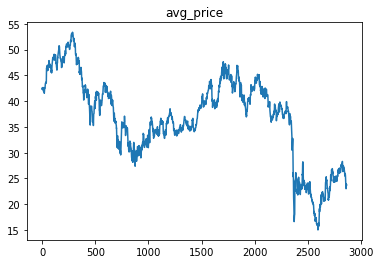

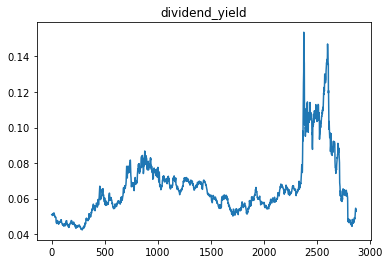

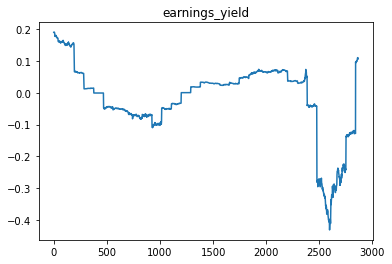

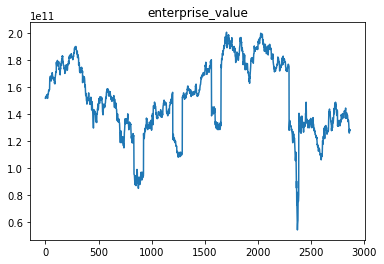

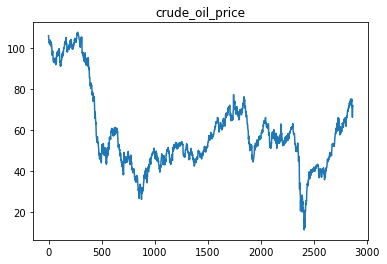

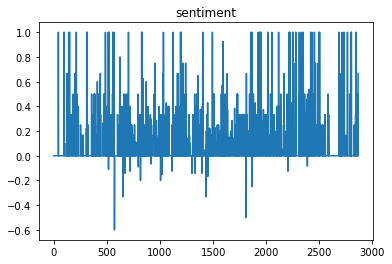

In [20]:
df = pd.read_csv("data\\6_extended_data\\BP_final_data_with_sentiment.csv", index_col=0)
df['sentiment'] = df['sentiment']-1
for col in df.columns[1:]:
    df[col].plot(title=col)
    plt.show()

# DATA PREPARATION

In [85]:
data_paths = ['data\\6_extended_data\\BP_final_data_with_sentiment.csv', 'data\\6_extended_data\\VLKAF_final_data_with_sentiment.csv']
input_window_size = 28
output_window_size = 7
shift = 7
# for 1 day
# input_window_size = 14
# output_window_size = 1
# shift = 1

In [15]:
scaler.__dict__

{'feature_range': (0, 1),
 'copy': True,
 'n_features_in_': 6,
 'n_samples_seen_': 28,
 'scale_': array([4.28532078e-02, 3.57142857e+02, 3.57142857e+02, 1.38274336e-11,
        9.90687537e-03, 1.00000000e+00]),
 'min_': array([-12.71947235, -12.53571429, -12.53571429,  -3.03401549,
        -15.04255003,  -1.        ]),
 'data_min_': array([2.96814941e+02, 3.51000000e-02, 3.51000000e-02, 2.19420000e+11,
        1.51839500e+03, 1.00000000e+00]),
 'data_max_': array([3.20150417e+02, 3.79000000e-02, 3.79000000e-02, 2.91740000e+11,
        1.61933500e+03, 2.00000000e+00]),
 'data_range_': array([2.33354759e+01, 2.80000000e-03, 2.80000000e-03, 7.23200000e+10,
        1.00940000e+02, 1.00000000e+00])}

In [86]:
company_name_list = []
input_period_start_date_list = []
input_period_end_date_list = []
output_period_start_date_list = []
output_period_end_date_list = []
x_min_list = []
x_scale_list = []
X = []
Y = []
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
for path in data_paths:
    print(path)
    company_name = path.split('data\\6_extended_data\\')[1].replace("_final_data_with_sentiment.csv", "")
    df = pd.read_csv(path, index_col=0).reset_index(drop=True)
    df.timestamp = pd.to_datetime(df.timestamp)
    df.sort_values(by='timestamp', inplace=True)
    for i in range(0, df.shape[0] - input_window_size - output_window_size, shift):

        input_period_df = df.loc[i:i + input_window_size - 1, :].reset_index(drop=True)
        #print(input_period_df)
        cols = df.columns[1:]
        #Date column is not used in training.
        #print("columns", cols)
        input_period = scaler.fit_transform(input_period_df[cols])
        
        #print(df_for_training_scaled)
        #input_period = input_period_df.avg_price
        input_period_start_date = input_period_df.timestamp.min()
        input_period_end_date = input_period_df.timestamp.max()

        output_period_df = df.loc[
                           i + input_window_size: i + input_window_size + output_window_size - 1,
                           :].reset_index(drop=True)
        #output_period = output_period_df.avg_price
        output_period = scaler.transform(output_period_df[cols]) #cols[0] / 'avg_price'
        #print(df_for_training_scaled)
        output_period_start_date = output_period_df.timestamp.min()
        output_period_end_date = output_period_df.timestamp.max()

        input_period_min = input_period.min()
        input_period_max = input_period.max()
        #         input_period = (input_period - input_period_min) / (input_period_max - input_period_min)
        #         output_period = (output_period - input_period_min) / (input_period_max - input_period_min)

        # we are testing different periods
        # if len(input_period) != 90:
        #    print("zle", company_name, i, df.shape[0])
        # if len(output_period) != 30:
        #    print("zle", company_name, i, df.shape[0])

        company_name_list.append(company_name)
        input_period_start_date_list.append(input_period_start_date)
        input_period_end_date_list.append(input_period_end_date)
        output_period_start_date_list.append(output_period_start_date)
        output_period_end_date_list.append(output_period_end_date)

        # Check
        input_period_days_span = (input_period_end_date - input_period_start_date).days
        output_period_days_span = (output_period_end_date - output_period_start_date).days

        # assert input_period_days_span == self.input_window_size - 1, \
        #     f"Input size mismatch {input_period_days_span} != {self.input_window_size - 1}"
        # assert output_period_days_span == self.output_window_size - 1, \
        #     f"Output size mismatch {output_period_days_span} != {self.output_window_size - 1}"

        x_min_list.append(scaler.min_[0])
        x_scale_list.append(scaler.scale_[0])

        # if output_averaging:
        #     output_period = _series_averaging(output_period)
        #     print(output_period)
        #     break
        # if input_averaging:
        #     input_period = _series_averaging(input_period)
        # #         print("input_period", input_period)
        # #         print(X_df)
        X.append(input_period)
        #print(X_df)
        Y.append(output_period[:,0])
X = np.array(X)
Y = np.array(Y)
assert np.isnan(X).sum() == 0, 'Nans in X array'
assert np.isnan(Y).sum() == 0, 'Nans in Y array'

data\6_extended_data\BP_final_data_with_sentiment.csv
data\6_extended_data\VLKAF_final_data_with_sentiment.csv


In [52]:
cols[0]

'avg_price'

In [63]:
output_period

array([[ 0.62739461,  0.42857143,  0.42857143,  0.05420354,  0.81404795,
         1.        ],
       [ 0.59434293,  0.5       ,  0.5       ,  0.04673673,  0.85867842,
         0.25      ],
       [ 0.68860917,  0.17857143,  0.17857143,  0.07688053,  0.74603725,
         0.5       ],
       [ 0.99933958,  0.10714286,  0.10714286,  0.08434735,  0.48533782,
         0.        ],
       [ 1.09155333, -0.07142857, -0.07142857,  0.10536504,  0.45219933,
         0.        ],
       [ 1.21077078, -0.16666667, -0.16666667,  0.11513643,  0.57375669,
         0.        ],
       [ 1.32998824, -0.26190476, -0.26190476,  0.12490782,  0.69531405,
         1.        ]])

In [55]:
output_period[:,0]

array([0.62739461, 0.59434293, 0.68860917, 0.99933958, 1.09155333,
       1.21077078, 1.32998824])

In [64]:
Y

array([[ 1.23116023,  1.59091027,  1.65033438, ...,  1.7691826 ,
         1.83412435,  1.69981338],
       [ 1.00645839,  1.06217911,  1.05397866, ...,  1.03757776,
         2.02849474,  2.38031811],
       [ 1.01458928,  0.99599394,  1.02722826, ...,  1.08969688,
         1.10535712,  1.08568613],
       ...,
       [ 0.12380199,  0.1142739 , -0.24364351, ...,  0.16733464,
         0.1556634 ,  0.14399217],
       [ 0.35887365,  0.26699752,  0.43305499, ...,  0.58998101,
         0.52307722,  0.45617343],
       [ 0.62739461,  0.59434293,  0.68860917, ...,  1.09155333,
         1.21077078,  1.32998824]])

In [49]:
X.shape, Y.shape

((748, 28, 6), (748, 7))

In [65]:
# X.shaoe[0] - ilosc przykladow uczacych
# X.shape[1] - ilosc dni w sekwencji
# X.shape[2] - ilosc featurow

# Y.shape[0] - ilosc przykladow uczacych
# Y.shape[1] - ilosc dni w sekwencji

In [87]:
normalization_arrays = (x_min_list, x_scale_list, company_name_list, input_period_start_date_list, input_period_end_date_list, \
        output_period_start_date_list, output_period_end_date_list)

# SPLIT

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [89]:
X_train.shape, X_test.shape

((501, 28, 6), (247, 28, 6))

In [90]:
Y_train.shape, Y_test.shape

((501, 7), (247, 7))

In [91]:
x_min_train, x_min_test = train_test_split(x_min_list, test_size=0.33, random_state=7)
x_max_train, x_max_test = train_test_split(x_scale_list, test_size=0.33, random_state=7)
company_name_train, company_name_test = train_test_split(company_name_list, test_size=0.33,
                                                         random_state=7)
input_period_start_date_train, input_period_start_date_test = train_test_split(input_period_start_date_list,
                                                                               test_size=0.33,
                                                                               random_state=7)
input_period_end_date_train, input_period_end_date_test = train_test_split(input_period_end_date_list,
                                                                           test_size=0.33,
                                                                           random_state=7)
output_period_start_date_train, output_period_start_date_test = train_test_split(
    output_period_start_date_list, test_size=0.33, random_state=7)
output_period_end_date_train, output_period_end_date_test = train_test_split(output_period_end_date_list,
                                                                             test_size=0.33,
                                                                             random_state=7)

In [92]:
normalization_arrays = (x_min_train, x_min_test, x_max_train, x_max_test,
                      company_name_train, company_name_test,
                      input_period_start_date_train, input_period_start_date_test,
                      input_period_end_date_train, input_period_end_date_test,
                      output_period_start_date_train, output_period_start_date_test,
                      output_period_end_date_train, output_period_end_date_test)

# LSTM modelling

In [93]:
def denormalize_y(array, x_max, x_min):
    denorm_array = np.multiply(array, (x_max - x_min)[:, None]) + x_min[:, None]
    return denorm_array


def denormalize_x(array, x_max, x_min):
    denorm_array = np.multiply(array, (x_max - x_min)[:, None]) + x_min[:, None]
    return denorm_array

In [94]:
experiment_name = 'Experiment 2 - predict 7 days'
experiment_id = 2
input_averaging = False
output_averaging = False
optimizer = Adam()
optimizer_name = 'Adam'
activation_function = 'sigmoid'
use_log = False
architecture_name = '2xLSTM'
epochs=350
frequency=shift
n_features=X.shape[-1]

In [95]:
class Model:
    def __init__(self, experiment_name):
        self.experiment_name = experiment_name

class NeuralNetworkModel(Model):
    def __init__(self, experiment_name, experiment_id, input_window_size, output_window_size, optimizer_name,
                 activation="tanh", freq=30, input_averaging=False,
                 output_averaging=False, n_features=1, optimizer=Adam(), loss=MeanSquaredError(), use_log=True):
        super().__init__(experiment_name)
        self.model = Sequential()
        self.experiment_name = experiment_name
        self.experiment_id = experiment_id
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size
        self.input_averaging = input_averaging
        self.output_averaging = output_averaging
        self.freq = freq
        self.use_log = use_log
        self.optimizer = optimizer
        self.loss = loss
        self.batch_size = None
        self.n_features = n_features
        self.n_steps = input_window_size if not input_averaging else math.ceil(input_window_size / freq)
        self.output_size = output_window_size if not output_averaging else math.ceil(output_window_size / freq)
        self.architecture_name = None
        self.model_details = None
        self.optimizer_name = optimizer_name
        self.activation = activation
        self.results = None
        self.epochs = None

    def generate_saving_name(self):
        return f"{self.experiment_name}_input_window_size_{self.input_window_size}_output_window_size_{self.output_window_size}_freq_{self.freq}_n_steps_{self.n_steps}_output_size_{self.output_size}_use_log_{self.use_log}_architecture_{self.architecture_name}_optimizer_{self.optimizer_name}"

    def prepare(self, layers_list, architecture_name, optimizer=Adam(), optimizer_name='Adam', activation="tanh"):
        self.architecture_name = architecture_name
        self.optimizer = optimizer
        self.optimizer_name = optimizer_name
        self.activation = activation
        # prepare model
        self.model = Sequential()
        for idx, layer in enumerate(layers_list):
            if idx == 0:
                layer._batch_input_shape = (None, self.n_steps, self.n_features)
            # if idx == len(layers_list)-1:
            #     layer.units = self.output_size
            self.model.add(layer)
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['mape', 'mse'])

    def fit(self, X_train, Y_train, batch_size=128, validation_split=0.2, epochs=10):
        # epochs zmień jak będziesz trenował
        #epochs = 3
        self.batch_size = batch_size
        print("X_train.shape: ", X_train.shape)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], self.n_features)) # TODO: self.n_features zamiast 1
        print("X_train.shape after reshape: ", X_train.shape)
        callback = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True, min_delta=0.001)
        self.results = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[callback]) # validation_split=validation_split,
        # self.model_details = [(l.name, l._build_input_shape.dims[1].value) for l in self.model.layers]
        #print(self.model.summary())
#         with open(
#                 f'{LSTM_MODEL_RESULTS}/{self.experiment_name}_input_window_{self.n_steps}_input_averaging_{self.input_averaging}_output_window{self.output_size}_output_averaging_{self.output_averaging}_modelsummary.txt',
#                 # _architecture_{self.architecture_name}
#                 'w') as f:
#             self.model.summary(print_fn=lambda x: f.write(x + '\n'))

    def test(self, X_test, Y_test, normalization_arrays):
        print("X_test_shape_before_reshape", X_test.shape)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], self.n_features))
        print("X_test_shape_after_reshape", X_test.shape)
        # mse_test_score = self.model.evaluate(X_test, Y_test, batch_size=self.batch_size, verbose=0)
        Y_predict = self.model.predict(X_test)
        #print("x_test before denormalisation: ", X_test)
        #print("y_test before denormalisation: ", Y_test)
        #print("y_predict before denormalisation: ", Y_predict)
        # denormalize values
        _, x_min_test, _, x_max_test, _, company_name_test, _, input_period_start_date_test, _, input_period_end_date_test, _, output_period_start_date_test, _, output_period_end_date_test = normalization_arrays
        #_, x_min_test, _, x_max_test, _, _, _, _, _, _, _, _, _, _ = normalization_arrays
        x_min_test = np.array(x_min_test)
        x_max_test = np.array(x_max_test)
        #print("x_min_test", x_min_test)
        #print("x_max_test", x_max_test)
        #X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
        print("X_test_shape_after_returning from reshape", X_test.shape)
        #X_test = denormalize_x(array=X_test, x_min=x_min_test, x_max=x_max_test)
        Y_test = denormalize_y(array=Y_test, x_min=x_min_test, x_max=x_max_test)
        Y_predict = denormalize_y(array=Y_predict, x_min=x_min_test, x_max=x_max_test)
        # # calculate errors
        # Y_test = np.array(Y_test)
        # Y_predict = np.array(Y_predict)
        # print("y_test after denormalisation: ", Y_test)
        # print("y_predict after denormalisation: ", Y_predict)
        if self.use_log:
            print("reversing log operation (using exponent)")
            X_test = np.exp(X_test)
            Y_test = np.exp(Y_test)
            Y_predict = np.exp(Y_predict)
        # show predictions plot
#         self.save_predictions(X_test, Y_test, Y_predict, company_name_test, input_period_start_date_test,
#                               input_period_end_date_test, output_period_start_date_test, output_period_end_date_test)
        # save_results
#         self.save_results(X_test, Y_test, Y_predict, company_name_test, input_period_start_date_test, input_period_end_date_test, output_period_start_date_test, output_period_end_date_test)
        # calculate errors
        mse_test_score = ((Y_test - Y_predict) ** 2).mean()
        mape_test_score = (abs((Y_test - Y_predict) / Y_test)).mean() * 100
        return mse_test_score, mape_test_score

    def run(self, X_train, Y_train, X_test, Y_test, normalization_arrays, epochs):
        # measure execution time
        start_time = datetime.now()
        self.epochs = epochs
        self.fit(X_train, Y_train, epochs=epochs)
        end_time = datetime.now()
        execution_time = end_time - start_time
        # history = self.results.history
        # calculate train errors
#         mse_train_score = self.results.history['mse'][-1]
#         mape_train_score = self.results.history['mape'][-1]
#         mse_val_score = self.results.history['val_mse'][-1]
#         mape_val_score = self.results.history['val_mape'][-1]
        # test errors
        mse_test_score, mape_test_score = self.test(X_test, Y_test, normalization_arrays)
        print(f"MSE TEST SCORE: {mse_test_score}")
#         print(f"MSE VALIDATION SCORE: {mse_val_score}")
#         print(f"MSE TRAIN SCORE: {mse_train_score}")
        print(f"MAPE TEST SCORE: {mape_test_score}")
#         print(f"MAPE VALIDATION SCORE: {mape_val_score}")
#         print(f"MAPE TRAIN SCORE: {mape_train_score}")
        #plot train errors
        #self.plot_history()
        #Save experiment to MASTER TABLE
#         self.save_experiment(mse_test_score=mse_test_score, mape_test_score=mape_test_score,
#                              mse_train_score=mse_train_score, mape_train_score=mape_train_score,
#                              mse_val_score=mse_val_score, mape_val_score=mape_val_score, exec_time=execution_time)

    def plot_history(self):
        history = self.results.history
        fig = plt.figure(figsize=(16, 5))
        plt.plot(history['val_loss'])
        plt.plot(history['loss'])
        plt.legend(['val_loss', 'loss'])
        plt.title(f'Loss(mse) for {self.experiment_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        date_string = dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
        # TODO: date and plot id !!!!
        plt.savefig(
            f"{LSTM_PLOTS_PATH}/{self.experiment_name}_nn_training_history_mse_input_window_{self.n_steps}_input_averaging_{self.input_averaging}_output_window{self.output_size}_output_averaging_{self.output_averaging}_{date_string}.png")  # _{self.architecture_name}
        #plt.show()
        plt.close(fig)
        ###
        fig2 = plt.figure(figsize=(16, 5))
        plt.plot(history['val_mape'])
        plt.plot(history['mape'])
        plt.legend(['val_mape', 'mape'])
        plt.title(f'MAPE for {self.experiment_name}')
        plt.xlabel('Epochs')
        plt.ylabel('MAPE')
        plt.savefig(
            f"{LSTM_PLOTS_PATH}/{self.experiment_name}_nn_training_history_mape_input_window_{self.n_steps}_input_averaging_{self.input_averaging}_output_window{self.output_size}_output_averaging_{self.output_averaging}_{date_string}.png")  # _{self.architecture_name}
        #plt.show()
        plt.close(fig2)

    def save_predictions(self, X_test, Y_test, Y_predict, company_name_test, input_period_start_date_test,
                         input_period_end_date_test, output_period_start_date_test, output_period_end_date_test):
        imageid = 0
        for i in range(len(Y_test)):  # len of X_test or Y_predict can be also used here
            imageid += 1
            company = company_name_test[i]

            input_start_date = input_period_start_date_test[i]
            input_end_date = input_period_end_date_test[i]
            output_start_date = output_period_start_date_test[i]
            output_end_date = output_period_end_date_test[i]

            # for clarity - change input_end_date in input_period_range to output_start_date
            if self.input_averaging:
                input_per_range = []
                input_per_range.append(pd.Timestamp(input_start_date)) #here first value is added
                for period in range(self.n_steps): #we start from 0 to n_steps-1, but we add +1 because of chart (the last date from input set + first from the output set)
                    input_per_range.append(pd.Timestamp(input_start_date) + DateOffset(days=30*(period+1)))
                input_period_range = pd.DatetimeIndex(input_per_range)
            else:
                input_period_range = pd.date_range(input_start_date, output_start_date)

            if self.output_averaging:
                output_per_range = []
                output_per_range.append(pd.Timestamp(output_start_date)) #here first value is added
                for period in range(self.output_size-1): # -1 because we have added already first value
                    output_per_range.append(pd.Timestamp(output_start_date) + DateOffset(days=30 * (period + 1)))
                output_period_range = pd.DatetimeIndex(output_per_range)
            else:
                output_period_range = pd.date_range(output_start_date, output_end_date)

            assert len(input_period_range) == (self.n_steps + 1), 'wrong input period len'
            assert len(output_period_range) == (self.output_size), 'wrong output period len'

            # temporary condition
            # if len(input_period_range) > self.input_window_size:
            #    input_period_range = input_period_range[:self.input_window_size]
            # if len(output_period_range) > self.output_window_size:
            #    output_period_range = output_period_range[:self.output_window_size]
            # x ranges
            # X_test_len = range(len(X_test[i]))
            # Y_test_len = range(X_test_len[-1], X_test_len[-1] + len(Y_test[i]))
            # Y_predict_len = range(X_test_len[-1], X_test_len[-1] + len(Y_predict[i]))
            fig = plt.figure(figsize=(14, 8))
            plt.title(f"{self.experiment_name} {company} company")
            plt.ylabel("Company price [\$]")
            plt.xlabel("Time periods")

            # for better plot - fill the hole + period tak samo
            tmp = np.append(X_test[i], Y_test[i][0])
            # input_period_range = ^up (u gory)

            plt.plot(input_period_range, tmp, "b-", label='training')  # "bo-" #X_test[i]
            plt.plot(output_period_range, Y_test[i], "g-", label='actual')  # "go-"
            plt.plot(output_period_range, Y_predict[i], "r-", label='forecast')  # "ro-"
            plt.legend()
            # plt.ylim(min,max) #zakres y od min do max
            date_string = dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
            plt.savefig(
                f"{LSTM_PLOTS_PATH}/{self.experiment_name}_prediction_plot_id_{imageid}_input_window_{self.n_steps}_input_averaging_{self.input_averaging}_output_window{self.output_size}_output_averaging_{self.output_averaging}_{date_string}.png")  # _{self.architecture_name}
            # plt.show()
            plt.close(fig)
            # print just 5/10 plots
            # TODO: maybe change this condition
            if i > 20:
                break

    def save_results(self, X_test, Y_test, Y_predict, company_name_test, input_period_start_date_test, input_period_end_date_test,
                     output_period_start_date_test, output_period_end_date_test):
        # 1. Save experiment results
        df = pd.DataFrame()
        data_tuples = list(zip(X_test, Y_test, Y_predict, company_name_test, input_period_start_date_test, input_period_end_date_test,
                               output_period_start_date_test, output_period_end_date_test))
        df = df.append(data_tuples, ignore_index=True)
        df.columns = ['x_test', 'y_test', 'y_predict', 'company_name', 'x_start_date', 'x_end_date', 'y_start_date',
                      'y_end_date']
        # print(df)
        date_string = dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
        df.to_csv(f"{LSTM_MODEL_RESULTS}/{self.experiment_name}_results_{date_string}.csv")
        # 2. Save loss and val_loss values
        df2 = pd.DataFrame()
        data_tuples2 = list(zip(self.results.history['mse'], self.results.history['val_mse'],
                                self.results.history['mape'], self.results.history['val_mape']))
        df2 = df2.append(data_tuples2, ignore_index=True)
        df2.columns = ['mse_train', 'mse_val', 'mape_train', 'mape_val']
        df2.to_csv(
            f"{LSTM_MODEL_RESULTS}/{self.experiment_name}_errors_input_window_{self.n_steps}_input_averaging_{self.input_averaging}_output_window{self.output_size}_output_averaging_{self.output_averaging}_{date_string}.csv")

    def save_experiment(self, mse_test_score, mape_test_score, mse_train_score, mape_train_score,
                        mse_val_score, mape_val_score, exec_time):
        MASTER_COLUMN_NAMES = ['timestamp', 'experiment_id', 'experiment_desc', 'model_name',  # 'model_details',
                               'optimizer', 'activation_func', 'epochs',
                               'input_size', 'output_size', 'input_averaging', 'output_averaging', 'use_log',
                               'MSE_test', 'MSE_val', 'MSE_train',
                               'MAPE_test', 'MAPE_val', 'MAPE_train', 'exec_runtime_hours', 'exec_runtime']
        master_table_df = pd.DataFrame(columns=MASTER_COLUMN_NAMES)
        exec_hours = exec_time.seconds // 3600
        exec_minutes = (exec_time.seconds % 3600) // 60
        exec_seconds = (exec_time.seconds % 3600) % 60
        exec_time_h = f"{exec_hours}h {exec_minutes}min {exec_seconds}s"
        print(f"Duration of model training: {exec_time_h}")
        master_table_values = [datetime.now().strftime('%Y-%m-%d_%H_%M'),
                               self.experiment_id,
                               self.experiment_name,
                               self.architecture_name,
                               # self.model_details,
                               self.optimizer_name,
                               self.activation,
                               self.epochs,
                               self.n_steps,
                               self.output_size,
                               self.input_averaging,
                               self.output_averaging,
                               self.use_log,
                               mse_test_score, mse_val_score, mse_train_score,
                               mape_test_score, mape_val_score, mape_train_score,
                               exec_time_h,
                               exec_time]
        master_table_df = master_table_df.append(pd.Series(master_table_values, index=master_table_df.columns),
                                                 ignore_index=True)
        # SAVE MASTER TABLE WITH ALL THE DATA
        print(master_table_df)
        master_file_name = LSTM_MODEL_RESULTS + f'/MASTER_TABLE.csv'
        file_exists = os.path.isfile(master_file_name)
        if not file_exists:
            with open(master_file_name, 'x') as f:
                master_table_df.to_csv(master_file_name)
                f.close()
        else:
            master_table_df.to_csv(master_file_name, mode='a', header=None)

In [96]:
nn_model = NeuralNetworkModel(
    experiment_name=experiment_name,
    experiment_id=experiment_id,
    input_window_size=input_window_size,
    output_window_size=output_window_size,
    input_averaging=input_averaging,
    output_averaging=output_averaging,
    optimizer=optimizer,
    optimizer_name=optimizer_name,
    activation=activation_function,
    use_log=use_log,
    n_features=n_features,
    freq=frequency
)

architecture = [
    LSTM(10, return_sequences=True, activation=activation_function, input_shape=(input_window_size, n_features), recurrent_dropout=0.4),
    LSTM(nn_model.output_size, activation=activation_function)
]
nn_model.prepare(layers_list=architecture, architecture_name=architecture_name, activation=activation_function,
                 optimizer=optimizer, optimizer_name=optimizer_name)
nn_model.run(X_train, Y_train, X_test, Y_test, normalization_arrays, epochs=epochs)

X_train.shape:  (501, 28, 6)
X_train.shape after reshape:  (501, 28, 6)
Train on 400 samples, validate on 101 samples
Epoch 1/350
400/400 [==============================] - 3s 8ms/sample - loss: 0.3098 - mean_absolute_percentage_error: 337.3548 - mean_squared_error: 0.3098 - val_loss: 0.3372 - val_mean_absolute_percentage_error: 289.1271 - val_mean_squared_error: 0.3372
Epoch 2/350
400/400 [==============================] - 0s 627us/sample - loss: 0.3075 - mean_absolute_percentage_error: 343.2458 - mean_squared_error: 0.3075 - val_loss: 0.3346 - val_mean_absolute_percentage_error: 292.9311 - val_mean_squared_error: 0.3346
Epoch 3/350
400/400 [==============================] - 0s 695us/sample - loss: 0.3055 - mean_absolute_percentage_error: 349.4446 - mean_squared_error: 0.3055 - val_loss: 0.3320 - val_mean_absolute_percentage_error: 297.0681 - val_mean_squared_error: 0.3320
Epoch 4/350
400/400 [==============================] - 0s 645us/sample - loss: 0.3031 - mean_absolute_percentage_

400/400 [==============================] - 0s 615us/sample - loss: 0.2707 - mean_absolute_percentage_error: 485.8103 - mean_squared_error: 0.2707 - val_loss: 0.2880 - val_mean_absolute_percentage_error: 392.2881 - val_mean_squared_error: 0.2880
Epoch 33/350
400/400 [==============================] - 0s 567us/sample - loss: 0.2688 - mean_absolute_percentage_error: 485.2125 - mean_squared_error: 0.2688 - val_loss: 0.2872 - val_mean_absolute_percentage_error: 394.3115 - val_mean_squared_error: 0.2872
Epoch 34/350
400/400 [==============================] - 0s 565us/sample - loss: 0.2698 - mean_absolute_percentage_error: 491.2952 - mean_squared_error: 0.2698 - val_loss: 0.2864 - val_mean_absolute_percentage_error: 395.0191 - val_mean_squared_error: 0.2864
Epoch 35/350
400/400 [==============================] - 0s 565us/sample - loss: 0.2684 - mean_absolute_percentage_error: 490.6764 - mean_squared_error: 0.2684 - val_loss: 0.2855 - val_mean_absolute_percentage_error: 395.3864 - val_mean_squ

Epoch 64/350
400/400 [==============================] - 0s 722us/sample - loss: 0.2291 - mean_absolute_percentage_error: 439.2745 - mean_squared_error: 0.2291 - val_loss: 0.2467 - val_mean_absolute_percentage_error: 368.4586 - val_mean_squared_error: 0.2467
Epoch 65/350
400/400 [==============================] - 0s 710us/sample - loss: 0.2255 - mean_absolute_percentage_error: 437.2943 - mean_squared_error: 0.2255 - val_loss: 0.2448 - val_mean_absolute_percentage_error: 369.2709 - val_mean_squared_error: 0.2448
Epoch 66/350
400/400 [==============================] - 0s 645us/sample - loss: 0.2232 - mean_absolute_percentage_error: 442.0864 - mean_squared_error: 0.2232 - val_loss: 0.2430 - val_mean_absolute_percentage_error: 368.9548 - val_mean_squared_error: 0.2430
Epoch 67/350
400/400 [==============================] - 0s 627us/sample - loss: 0.2187 - mean_absolute_percentage_error: 443.3142 - mean_squared_error: 0.2187 - val_loss: 0.2411 - val_mean_absolute_percentage_error: 368.8578 -

Epoch 96/350
400/400 [==============================] - 0s 602us/sample - loss: 0.1797 - mean_absolute_percentage_error: 378.2910 - mean_squared_error: 0.1797 - val_loss: 0.2030 - val_mean_absolute_percentage_error: 321.9277 - val_mean_squared_error: 0.2030
Epoch 97/350
400/400 [==============================] - 0s 640us/sample - loss: 0.1795 - mean_absolute_percentage_error: 371.7315 - mean_squared_error: 0.1795 - val_loss: 0.2021 - val_mean_absolute_percentage_error: 322.5309 - val_mean_squared_error: 0.2021
Epoch 98/350
400/400 [==============================] - 0s 635us/sample - loss: 0.1769 - mean_absolute_percentage_error: 356.0435 - mean_squared_error: 0.1769 - val_loss: 0.2013 - val_mean_absolute_percentage_error: 323.0384 - val_mean_squared_error: 0.2013
Epoch 99/350
400/400 [==============================] - 0s 602us/sample - loss: 0.1811 - mean_absolute_percentage_error: 375.5798 - mean_squared_error: 0.1811 - val_loss: 0.2005 - val_mean_absolute_percentage_error: 323.1130 -

Epoch 128/350
400/400 [==============================] - 0s 762us/sample - loss: 0.1617 - mean_absolute_percentage_error: 330.0766 - mean_squared_error: 0.1617 - val_loss: 0.1843 - val_mean_absolute_percentage_error: 304.3513 - val_mean_squared_error: 0.1843
Epoch 129/350
400/400 [==============================] - 0s 607us/sample - loss: 0.1616 - mean_absolute_percentage_error: 318.6783 - mean_squared_error: 0.1616 - val_loss: 0.1839 - val_mean_absolute_percentage_error: 299.1452 - val_mean_squared_error: 0.1839
Epoch 130/350
400/400 [==============================] - 0s 572us/sample - loss: 0.1603 - mean_absolute_percentage_error: 329.6779 - mean_squared_error: 0.1603 - val_loss: 0.1836 - val_mean_absolute_percentage_error: 295.9135 - val_mean_squared_error: 0.1836
Epoch 131/350
400/400 [==============================] - 0s 592us/sample - loss: 0.1594 - mean_absolute_percentage_error: 319.7982 - mean_squared_error: 0.1594 - val_loss: 0.1832 - val_mean_absolute_percentage_error: 293.84

Epoch 160/350
400/400 [==============================] - 0s 587us/sample - loss: 0.1517 - mean_absolute_percentage_error: 315.3820 - mean_squared_error: 0.1517 - val_loss: 0.1748 - val_mean_absolute_percentage_error: 288.8957 - val_mean_squared_error: 0.1748
Epoch 161/350
400/400 [==============================] - 0s 557us/sample - loss: 0.1477 - mean_absolute_percentage_error: 282.5197 - mean_squared_error: 0.1477 - val_loss: 0.1746 - val_mean_absolute_percentage_error: 286.2346 - val_mean_squared_error: 0.1746
Epoch 162/350
400/400 [==============================] - 0s 617us/sample - loss: 0.1480 - mean_absolute_percentage_error: 304.8175 - mean_squared_error: 0.1480 - val_loss: 0.1744 - val_mean_absolute_percentage_error: 285.2748 - val_mean_squared_error: 0.1744
Epoch 163/350
400/400 [==============================] - 0s 552us/sample - loss: 0.1507 - mean_absolute_percentage_error: 301.1970 - mean_squared_error: 0.1507 - val_loss: 0.1741 - val_mean_absolute_percentage_error: 286.83

Epoch 192/350
400/400 [==============================] - 0s 620us/sample - loss: 0.1448 - mean_absolute_percentage_error: 303.3773 - mean_squared_error: 0.1448 - val_loss: 0.1691 - val_mean_absolute_percentage_error: 290.4691 - val_mean_squared_error: 0.1691
Epoch 193/350
400/400 [==============================] - ETA: 0s - loss: 0.1407 - mean_absolute_percentage_error: 303.7149 - mean_squared_error: 0.140 - 0s 602us/sample - loss: 0.1420 - mean_absolute_percentage_error: 295.5643 - mean_squared_error: 0.1420 - val_loss: 0.1690 - val_mean_absolute_percentage_error: 289.3038 - val_mean_squared_error: 0.1690
Epoch 194/350
400/400 [==============================] - 0s 597us/sample - loss: 0.1445 - mean_absolute_percentage_error: 292.0638 - mean_squared_error: 0.1445 - val_loss: 0.1689 - val_mean_absolute_percentage_error: 289.5563 - val_mean_squared_error: 0.1689
Epoch 195/350
400/400 [==============================] - 0s 582us/sample - loss: 0.1432 - mean_absolute_percentage_error: 277.4

400/400 [==============================] - 0s 642us/sample - loss: 0.1394 - mean_absolute_percentage_error: 310.8179 - mean_squared_error: 0.1394 - val_loss: 0.1659 - val_mean_absolute_percentage_error: 297.6385 - val_mean_squared_error: 0.1659
Epoch 224/350
400/400 [==============================] - 0s 595us/sample - loss: 0.1396 - mean_absolute_percentage_error: 314.1476 - mean_squared_error: 0.1396 - val_loss: 0.1657 - val_mean_absolute_percentage_error: 295.3141 - val_mean_squared_error: 0.1657
Epoch 225/350
400/400 [==============================] - 0s 650us/sample - loss: 0.1395 - mean_absolute_percentage_error: 306.0456 - mean_squared_error: 0.1395 - val_loss: 0.1655 - val_mean_absolute_percentage_error: 294.4707 - val_mean_squared_error: 0.1655
Epoch 226/350
400/400 [==============================] - 0s 615us/sample - loss: 0.1367 - mean_absolute_percentage_error: 294.6843 - mean_squared_error: 0.1367 - val_loss: 0.1654 - val_mean_absolute_percentage_error: 294.5853 - val_mean_

Epoch 255/350
400/400 [==============================] - 0s 652us/sample - loss: 0.1364 - mean_absolute_percentage_error: 293.2540 - mean_squared_error: 0.1364 - val_loss: 0.1629 - val_mean_absolute_percentage_error: 281.8062 - val_mean_squared_error: 0.1629
Epoch 256/350
400/400 [==============================] - 0s 647us/sample - loss: 0.1355 - mean_absolute_percentage_error: 297.7336 - mean_squared_error: 0.1355 - val_loss: 0.1628 - val_mean_absolute_percentage_error: 282.0848 - val_mean_squared_error: 0.1628
Epoch 257/350
400/400 [==============================] - 0s 657us/sample - loss: 0.1329 - mean_absolute_percentage_error: 292.9762 - mean_squared_error: 0.1329 - val_loss: 0.1627 - val_mean_absolute_percentage_error: 281.8987 - val_mean_squared_error: 0.1627
Epoch 258/350
400/400 [==============================] - 0s 702us/sample - loss: 0.1357 - mean_absolute_percentage_error: 291.4356 - mean_squared_error: 0.1357 - val_loss: 0.1627 - val_mean_absolute_percentage_error: 284.52

Epoch 287/350
400/400 [==============================] - 0s 637us/sample - loss: 0.1334 - mean_absolute_percentage_error: 289.5477 - mean_squared_error: 0.1334 - val_loss: 0.1616 - val_mean_absolute_percentage_error: 280.3380 - val_mean_squared_error: 0.1616
Epoch 288/350
400/400 [==============================] - 0s 690us/sample - loss: 0.1310 - mean_absolute_percentage_error: 278.7869 - mean_squared_error: 0.1310 - val_loss: 0.1616 - val_mean_absolute_percentage_error: 278.6076 - val_mean_squared_error: 0.1616
Epoch 289/350
400/400 [==============================] - 0s 707us/sample - loss: 0.1315 - mean_absolute_percentage_error: 288.7888 - mean_squared_error: 0.1315 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 275.9183 - val_mean_squared_error: 0.1617
Epoch 290/350
400/400 [==============================] - 0s 620us/sample - loss: 0.1311 - mean_absolute_percentage_error: 282.1109 - mean_squared_error: 0.1311 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 274.86

In [97]:
Y_predict.shape

NameError: name 'Y_predict' is not defined

In [16]:
Y_test.shape

(247, 7)

In [78]:
Y_test

array([[ 8.70936893e-01,  7.92095165e-01,  8.11285786e-01, ...,
         8.49667029e-01,  6.06964080e-01,  5.06670292e-01],
       [-1.05237015e-01, -1.52677369e-01, -1.01761426e-01, ...,
         7.04603905e-05, -1.67188197e-01, -2.23594636e-01],
       [ 1.10953900e+00,  1.10963853e+00,  1.10555861e+00, ...,
         1.09739879e+00,  1.05896165e+00,  1.09767750e+00],
       ...,
       [ 5.04232781e-01,  1.98736677e-01,  1.93735367e-01, ...,
         1.83732745e-01,  1.78731434e-01, -7.28536571e-02],
       [ 2.12828788e-01,  1.06625586e-01,  2.96226503e-01, ...,
         8.27202477e-01,  8.66299367e-01,  9.05396258e-01],
       [-3.51614261e-01, -4.78285119e-01, -5.20869219e-01, ...,
        -6.06037418e-01, -8.46253156e-01, -4.65378059e-01]])

In [17]:
X_test

array([[[0.44006887, 0.53846154, 0.54545455, 0.44444444, 0.88015979,
         0.        ],
        [0.47467315, 0.56410256, 0.54545455, 0.43044619, 0.79094541,
         0.        ],
        [0.53487303, 0.5042735 , 0.5       , 0.4855643 , 0.80514869,
         0.        ],
        ...,
        [0.55191368, 0.51282051, 0.5       , 0.46981627, 0.00133156,
         0.        ],
        [0.56163899, 0.41025641, 0.40909091, 0.56517935, 0.1011984 ,
         0.        ],
        [0.59262127, 0.43589744, 0.40909091, 0.56255468, 0.        ,
         0.6       ]],

       [[0.97793028, 0.06153846, 0.93944637, 0.92962641, 1.        ,
         0.        ],
        [1.        , 0.        , 1.        , 1.        , 0.9888535 ,
         0.        ],
        [0.97056625, 0.03760684, 0.96193772, 0.95626991, 0.96974522,
         0.        ],
        ...,
        [0.        , 0.87692308, 0.11937716, 0.10251955, 0.42802548,
         0.        ],
        [0.11613009, 0.82564103, 0.17301038, 0.14943527, 0.477

In [91]:
X_test[:, :, 0].shape

(247, 28)

In [92]:
X_test[:, :, 0]

array([[0.44006887, 0.47467315, 0.53487303, ..., 0.55191368, 0.56163899,
        0.59262127],
       [0.97793028, 1.        , 0.97056625, ..., 0.        , 0.11613009,
        0.00528442],
       [0.        , 0.05634793, 0.09614209, ..., 0.84555129, 0.84899311,
        1.        ],
       ...,
       [0.53884262, 0.50998085, 0.49495933, ..., 0.13010986, 0.        ,
        0.20629625],
       [0.68841839, 0.56462731, 0.09549936, ..., 0.        , 0.07094293,
        0.14188586],
       [0.85664861, 0.37328195, 0.24885463, ..., 0.32127069, 0.27813668,
        0.01926802]])

In [88]:
X_test[:, 0][:, 0].shape

(247,)

In [89]:
X_test[:, 0][:, 0]

array([0.44006887, 0.97793028, 0.        , 0.19469803, 0.7163892 ,
       0.92155217, 0.        , 0.15442768, 0.16467727, 0.42761214,
       0.92263815, 0.5000396 , 0.33457555, 0.73021171, 0.57184547,
       1.        , 0.92354181, 0.08486318, 0.96514195, 0.        ,
       0.30865957, 0.62185273, 1.        , 0.33276639, 0.21749141,
       0.44235665, 0.94457921, 0.31741691, 1.        , 0.70761381,
       0.37483479, 0.77665077, 0.92272358, 0.96131593, 0.83197708,
       1.        , 0.51467251, 0.80163003, 0.        , 0.10794749,
       0.38987105, 0.30764881, 0.930461  , 0.58507299, 0.        ,
       0.39843563, 0.91206924, 0.81135045, 0.94438336, 0.78454917,
       0.37346371, 0.46448482, 0.3289455 , 0.67804413, 0.99465038,
       0.2714064 , 1.        , 1.        , 0.77567503, 0.15570201,
       0.99336705, 1.        , 0.        , 0.32351138, 0.72898913,
       0.63165164, 0.49043975, 0.40561098, 0.94102718, 0.38335294,
       0.50915809, 0.19841585, 0.80008054, 0.49528019, 0.     

In [66]:
X_test.shape

(247, 28, 6)

In [45]:
X_test.reshape(X_test.shape[0]*X_test.shape[1], 6).shape

(6916, 6)

In [43]:
X_test

array([[[0.44006887, 0.53846154, 0.54545455, 0.44444444, 0.88015979,
         0.        ],
        [0.47467315, 0.56410256, 0.54545455, 0.43044619, 0.79094541,
         0.        ],
        [0.53487303, 0.5042735 , 0.5       , 0.4855643 , 0.80514869,
         0.        ],
        ...,
        [0.55191368, 0.51282051, 0.5       , 0.46981627, 0.00133156,
         0.        ],
        [0.56163899, 0.41025641, 0.40909091, 0.56517935, 0.1011984 ,
         0.        ],
        [0.59262127, 0.43589744, 0.40909091, 0.56255468, 0.        ,
         0.6       ]],

       [[0.97793028, 0.06153846, 0.93944637, 0.92962641, 1.        ,
         0.        ],
        [1.        , 0.        , 1.        , 1.        , 0.9888535 ,
         0.        ],
        [0.97056625, 0.03760684, 0.96193772, 0.95626991, 0.96974522,
         0.        ],
        ...,
        [0.        , 0.87692308, 0.11937716, 0.10251955, 0.42802548,
         0.        ],
        [0.11613009, 0.82564103, 0.17301038, 0.14943527, 0.477

In [34]:
Y_test.shape

(247, 7)

In [35]:
Y_predict.shape

NameError: name 'Y_predict' is not defined

In [29]:
X_test

array([[[0.44006887, 0.53846154, 0.54545455, 0.44444444, 0.88015979,
         0.        ],
        [0.47467315, 0.56410256, 0.54545455, 0.43044619, 0.79094541,
         0.        ],
        [0.53487303, 0.5042735 , 0.5       , 0.4855643 , 0.80514869,
         0.        ],
        ...,
        [0.55191368, 0.51282051, 0.5       , 0.46981627, 0.00133156,
         0.        ],
        [0.56163899, 0.41025641, 0.40909091, 0.56517935, 0.1011984 ,
         0.        ],
        [0.59262127, 0.43589744, 0.40909091, 0.56255468, 0.        ,
         0.6       ]],

       [[0.97793028, 0.06153846, 0.93944637, 0.92962641, 1.        ,
         0.        ],
        [1.        , 0.        , 1.        , 1.        , 0.9888535 ,
         0.        ],
        [0.97056625, 0.03760684, 0.96193772, 0.95626991, 0.96974522,
         0.        ],
        ...,
        [0.        , 0.87692308, 0.11937716, 0.10251955, 0.42802548,
         0.        ],
        [0.11613009, 0.82564103, 0.17301038, 0.14943527, 0.477

In [28]:
X_test.reshape((X_test.shape[0], X_test.shape[1], 6)).shape

(247, 28, 6)

In [30]:
x_scale_list

[0.8976534710414549,
 0.4894179996947653,
 0.20561033288990901,
 0.19691736020218614,
 0.24972226855128873,
 0.2802305128818006,
 0.5151374520262577,
 0.5151374520262577,
 0.7343237588523992,
 0.41765460868933263,
 0.447080555306695,
 0.32551111277767925,
 0.3131579606348806,
 0.3744112116963195,
 0.8266213734003042,
 0.5449266288375764,
 0.3247009363762984,
 0.33659229051848194,
 0.2886340329789342,
 0.21191348746362687,
 0.2773680090231289,
 0.3842380076944209,
 0.3117442334955726,
 0.2451194007615606,
 0.4350012057908583,
 0.478111492337735,
 0.478111492337735,
 0.5992466596291149,
 0.3161162929302183,
 0.2730094904925566,
 0.42645945297599164,
 0.43175698828504905,
 0.9713786285555581,
 0.7081137602903479,
 0.7081137602903479,
 0.43273326685613434,
 0.3199795753063996,
 0.33254226916498625,
 0.5025665531685454,
 0.5690278800438164,
 0.3568207710412843,
 0.2515839072630703,
 0.23888288060097715,
 0.2370683783913172,
 0.2370683783913172,
 0.47987445508561904,
 0.7004496853933778,
 0.

In [31]:
x_min_list

[-37.28325579248193,
 -20.32755073168107,
 -8.539846256950328,
 -8.237415067336604,
 -10.7144991370829,
 -12.215407529018659,
 -23.656960458574904,
 -23.656960458574904,
 -34.14827317368644,
 -18.990961890438385,
 -20.328974255617574,
 -14.80115149949975,
 -14.239447553967143,
 -17.384445002406608,
 -39.58899600853245,
 -25.757141146555416,
 -14.943557031838385,
 -15.49082717769214,
 -13.283667060792217,
 -9.75279382027564,
 -13.07404997701232,
 -18.496786750587322,
 -14.818348834512586,
 -11.403750435725218,
 -20.23766855934816,
 -22.243299070298228,
 -22.243299070298228,
 -28.41962363707346,
 -14.992000249419796,
 -12.94763490871977,
 -20.787157445516165,
 -21.208739354735037,
 -48.965826522088996,
 -35.423993965343854,
 -35.423993965343854,
 -21.647850237269537,
 -16.007250784167102,
 -16.747439280056636,
 -25.821460649024864,
 -29.36843338771652,
 -18.04315798355344,
 -12.35730709100427,
 -11.466998969719095,
 -11.158968426621472,
 -11.158968426621472,
 -22.588014181307337,
 -32.97

In [19]:
X_train.shape

(501, 28, 6)

In [98]:
new_data = pd.read_csv('data/VLKAF_new.csv', sep=';')
new_data = new_data[:-3]
new_data

,timestamp,avg_price,dividend_yield,earnings_yield,enterprise_value,steel_price,sentiment
0,14.12.2021,309.92,0.0364,0.1371,2.230600e+11,43420.0,1
1,13.12.2021,312.00,0.0361,0.1362,2.237600e+11,43420.0,1
2,12.12.2021,312.00,0.0361,0.1362,2.237600e+11,43420.0,1
3,11.12.2021,312.00,0.0361,0.1362,2.237600e+11,43420.0,1
4,10.12.2021,310.25,0.0364,0.1370,2.231600e+11,43620.0,1
5,09.12.2021,311.71,0.0362,0.1363,2.235900e+11,43900.0,1
6,08.12.2021,321.26,0.0351,0.1323,2.264100e+11,43590.0,1
7,07.12.2021,296.50,0.0380,0.1433,2.191000e+11,43590.0,1
8,06.12.2021,285.00,0.0396,0.1491,2.157100e+11,43190.0,1
9,05.12.2021,285.00,0.0396,0.1491,2.157100e+11,43190.0,1


In [99]:
new_data.timestamp = pd.to_datetime(new_data.timestamp)
new_data.sort_values(by='timestamp', inplace=True)
cols = new_data.columns[1:]
X_new = scaler.transform(new_data[cols])
X_new 

array([[-1.20629241e-01,  1.17857143e+00,  3.90714286e+01,
        -1.46570796e-02,  4.21751585e+02,  0.00000000e+00],
       [-1.45055569e-01,  1.17857143e+00,  3.91785714e+01,
        -1.70077434e-02,  4.20364623e+02,  0.00000000e+00],
       [-6.29296818e-01,  1.75000000e+00,  4.12500000e+01,
        -6.30530973e-02,  4.16699079e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-1.34962210e-02,  1.03571429e+00,  3.86428571e+01,
        -4.42477876e-03,  4.16798147e+02,  0.00000000e+00],
       [ 1.04754921e+00,  0.00000000e+00,  3.47142857e+01,
         9.66537611e-02,  4.16798147e+02,  0.00000000e+00],
       [ 6.38301070e-01,  3.92857143e-01,  3.614

In [100]:
X_new.shape

(28, 6)

In [72]:
X_new[:-3, :]

array([[-1.20629241e-01,  1.17857143e+00,  3.90714286e+01,
        -1.46570796e-02,  4.21751585e+02,  0.00000000e+00],
       [-1.45055569e-01,  1.17857143e+00,  3.91785714e+01,
        -1.70077434e-02,  4.20364623e+02,  0.00000000e+00],
       [-6.29296818e-01,  1.75000000e+00,  4.12500000e+01,
        -6.30530973e-02,  4.16699079e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-5.06308111e-01,  1.60714286e+00,  4.07142857e+01,
        -5.12997788e-02,  4.12835397e+02,  0.00000000e+00],
       [-1.34962210e-02,  1.03571429e+00,  3.86428571e+01,
        -4.42477876e-03,  4.16798147e+02,  0.00000000e+00],
       [ 1.04754921e+00,  0.00000000e+00,  3.47142857e+01,
         9.66537611e-02,  4.16798147e+02,  0.00000000e+00],
       [ 6.38301070e-01,  3.92857143e-01,  3.614

In [41]:
X_new.shape

(28, 6)

In [102]:
X_new = X_new.reshape(1, X_new.shape[0], X_new.shape[1])

In [103]:
X_new.shape

(1, 28, 6)

In [44]:
X_train.shape

(501, 28, 6)

In [104]:
Y_pred = nn_model.model.predict(X_new)

In [105]:
Y_pred

array([[0.9169718, 0.984313 , 0.9999964, 0.9887707, 0.9734982, 1.       ,
        1.       ]], dtype=float32)

In [106]:
denormalize(Y_pred, i)

IndexError: list index out of range

In [107]:
def denormalize(array, i):
    #return array
    return (array*x_scale_list[i])-x_min_list[i] #here should be '+''


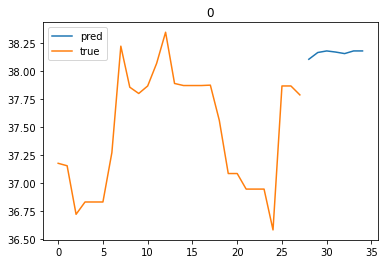

In [108]:
for i in range(1):
    _plot_x_train = denormalize(X_new[i, :, 0], i)
    _plot_y_pred = denormalize(Y_pred[i], i)
    #_plot_y_train = denormalize(Y_train[i], i)
    plt.plot(np.concatenate([[None]*len(_plot_x_train), _plot_y_pred]), label='pred')
    plt.plot(_plot_x_train, label='true')
    #plt.plot(np.concatenate([_plot_x_train, _plot_y_train]), label='true')
    plt.title(i)
    plt.legend()
    plt.show()

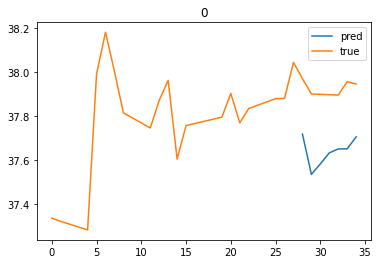

In [57]:
for i in range(1):
    _plot_x_train = denormalize(X_train[i, :, 0], i)
    _plot_y_pred = denormalize(Y_pred[i], i)
    #_plot_y_train = denormalize(Y_train[i], i)
    plt.plot(np.concatenate([[None]*len(_plot_x_train), _plot_y_pred]), label='pred')
    plt.plot(np.concatenate([_plot_x_train, _plot_y_train]), label='true')
    plt.title(i)
    plt.legend()
    plt.show()